In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pdb

import pickle
import adniEnsemble as adens
import tensorflow as tf
from tensorflow import keras
import os
import re

In [2]:
adnifulldf = pd.read_csv("../Dataset/ADNI/adnitable.csv")

In [3]:
# adnifulldf.Gender = adnifulldf.Gender.apply(lambda x: 'M' if x==1 else 'F')
adnifulldf = adnifulldf.fillna(-1)
adnifulldf.DX = adnifulldf.DX.apply(lambda x: 'CN' if x==1 else ('MCI' if x==2 else ('AD' if x==3 else -1)))

In [4]:
adnifulldf.head()

,RID,Gender,Educ,Age,APOE,MMSE,DX,mri_001,mri_002,mri_003,...,fdg_05,amyloid_01,amyloid_02,amyloid_03,amyloid_04,amyloid_05,amyloid_06,csf_01,csf_02,csf_03
0,1,2,18.0,61.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
1,1,2,18.0,61.25,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
2,1,2,18.0,61.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
3,1,2,18.0,62.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
4,1,2,18.0,62.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0


In [5]:
mri_vars = [fieldname for fieldname in adnifulldf.columns if 'mri_' in fieldname]
amyloid_vars = [fieldname for fieldname in adnifulldf.columns if 'amyloid_' in fieldname]
csf_vars = [fieldname for fieldname in adnifulldf.columns if 'csf_' in fieldname]
fdg_vars = [fieldname for fieldname in adnifulldf.columns if 'fdg_' in fieldname]
pet_vars = [fieldname for fieldname in adnifulldf.columns if 'pet_' in fieldname]
factors = ['RID','Gender','Educ','Age','APOE','MMSE','DX']
dx_stages = ['CN', 'AD']
# mridf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] != -1), factors+mri_vars]
# amyloiddf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["amyloid_01"] != -1), factors+amyloid_vars]
# csfdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["csf_01"] != -1), factors+csf_vars]
# fdgdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["fdg_01"] != -1), factors+fdg_vars]
# petdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["pet_01"] != -1), factors+pet_vars]

In [6]:
print(len(mridf), len(amyloiddf), len(csfdf), len(fdgdf), len(petdf))

NameError: name 'mridf' is not defined

In [7]:
dirpath = '../Dataset/ProcessedFiles/'
modality = 'csf_'
modality_files = [fname for fname in os.listdir(dirpath) if modality in fname]
perfdict = dict()

for file in modality_files:
    keyname = re.sub(modality+'|_cv.pckl','', file)
    if 'logistic_regression' in keyname:
        keyname = re.sub('logistic_regression','LR',keyname)
    elif 'random_forest' in keyname:
        keyname = re.sub('random_forest','RF',keyname)
    elif 'svm' in keyname:
        keyname = re.sub('svm','SVM', keyname)
    perfdict[keyname] = [gridout['test_score']['accuracy'] for gridout in pickle.load(open(dirpath+file,'rb'))]

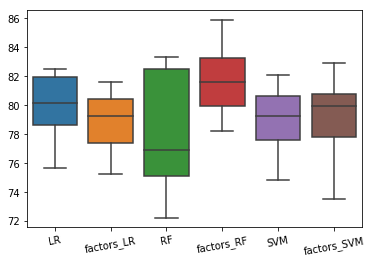

In [8]:
sns.boxplot(data=pd.DataFrame(perfdict), order=['LR','factors_LR','RF','factors_RF','SVM','factors_SVM'])
plt.xticks(rotation=10)
plt.show()

Keep all subjects who do not have any MRI for testing. Patients who have atleast MRI have 76% patients with Amyloid, 94% patients with CSF, 90% patients with FDG and 93% patients with PET. Using 80% of the patients with all MRI for training and 20% of it for testing.

In [9]:
# prepare training and test data
# all rows that are AD/CN, Education present and at least the MRI scans
adnidf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] !=-1)].copy()
adnidf["DX_bin"] = np.where(adnidf["DX"] == "CN", 0, 1) # CN: 0, AD: 1

training_df, testing2_df = train_test_split(adnidf, test_size=0.2, shuffle=True)

# all rows that are AD/CN, Education present and no MRI scans
testing1_df = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] == -1) &
                  ((adnifulldf["csf_01"] != -1)|(adnifulldf["pet_01"] != -1)|(adnifulldf["fdg_01"] != -1)|(adnifulldf["amyloid_01"] != -1))].copy()
testing1_df["DX_bin"] = np.where(testing1_df["DX"] == "CN", 0, 1) # CN: 0, AD: 1

# combine test data
testing_df = pd.concat([testing1_df, testing2_df], sort=False)

In [10]:
# train model for each modality
gs_num_cv = 10
csfout = adens.modalityModelTrainWrapper('random_forest', 'csf', training_df, gs_num_cv)
fdgout = adens.modalityModelTrainWrapper('random_forest', 'fdg', training_df, gs_num_cv)
petout = adens.modalityModelTrainWrapper('random_forest', 'pet', training_df, gs_num_cv)
amyloidout = adens.modalityModelTrainWrapper('logistic_regression', 'amyloid', training_df, gs_num_cv)

Fitting 10 folds for each of 44 candidates, totalling 440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 44 candidates, totalling 440 fits


[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 44 candidates, totalling 440 fits


[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed:    6.0s finished
/home/ksaboo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Training CV number: 0
Training CV number: 1
Training CV number: 2
Training CV number: 3
Training CV number: 4
Training CV number: 5
Training CV number: 6
Training CV number: 7


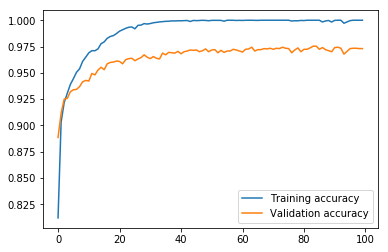

In [11]:
# DL features
mri_features = [item for sublist in [['Gender','Age','Educ','APOE'], mri_vars] for item in sublist]

# specify the model
dlmodel_def = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# perform cross validation to choose number of epochs
max_epochs = 100
validation_fraction = 1/8 # show as a fraction of training data
train_acc, val_acc, epoch_arr = adens.trainDeepLearningModelCV(dlmodel_def, training_df[mri_features].values,
                                                         training_df['DX_bin'].values.reshape(-1,1), validation_fraction, max_epochs)

plt.plot(epoch_arr, np.mean(train_acc, axis=0), label='Training accuracy')
plt.plot(epoch_arr, np.mean(val_acc, axis=0), label='Validation accuracy')
plt.legend()
plt.show()

In [12]:
dlmodel = dlmodel_def
dlmodel.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs_from_cv = 40 # pick this from the plot of training and validation performance
train_mean_list = training_df[mri_features].mean()
train_std_list = training_df[mri_features].std()
training_X = ((training_df[mri_features] - train_mean_list)/train_std_list).values
dlmodel_history = dlmodel.fit(training_X, 
                              training_df['DX_bin'].values.reshape(-1,1),
                              epochs=epochs_from_cv, verbose=1)
mriout = {'model':dlmodel,'features':mri_features,'train_mod_mean':train_mean_list,'train_mod_std':train_std_list}

Epoch 1/40
3037/3037 [==============================] - 0s 105us/step - loss: 0.4013 - acc: 0.8284
Epoch 2/40
3037/3037 [==============================] - 0s 31us/step - loss: 0.2553 - acc: 0.9088
Epoch 3/40
3037/3037 [==============================] - 0s 34us/step - loss: 0.2104 - acc: 0.9239
Epoch 4/40
3037/3037 [==============================] - 0s 29us/step - loss: 0.1849 - acc: 0.9358
Epoch 5/40
3037/3037 [==============================] - 0s 33us/step - loss: 0.1670 - acc: 0.9388
Epoch 6/40
3037/3037 [==============================] - 0s 33us/step - loss: 0.1499 - acc: 0.9480
Epoch 7/40
3037/3037 [==============================] - 0s 29us/step - loss: 0.1363 - acc: 0.9562
Epoch 8/40
3037/3037 [==============================] - 0s 36us/step - loss: 0.1244 - acc: 0.9588
Epoch 9/40
3037/3037 [==============================] - 0s 34us/step - loss: 0.1141 - acc: 0.9654
Epoch 10/40
3037/3037 [==============================] - 0s 37us/step - loss: 0.1031 - acc: 0.9700
Epoch 11/40
3037/3

In [13]:
print("Test accuracy is: %.2f%%" % (100*mriout['model'].evaluate(
    ((testing2_df[mriout['features']]-mriout['train_mod_mean'])/mriout['train_mod_std']).values, 
    testing2_df['DX_bin'].values.reshape(-1,1))[1]))

760/760 [==============================] - 0s 146us/step
Test accuracy is: 96.18%


In [14]:
# test csf model
aux_vars = ['Gender','Age','Educ','APOE', 'DX_bin']

csf_columns = [item for sublist in [aux_vars, csf_vars] for item in sublist]
fdg_columns = [item for sublist in [aux_vars, fdg_vars] for item in sublist]
pet_columns = [item for sublist in [aux_vars, pet_vars] for item in sublist]
amyloid_columns = [item for sublist in [aux_vars, amyloid_vars] for item in sublist]

modcolumn_dict = {'csf':csf_columns,'amyloid':amyloid_columns,'fdg':fdg_columns,'pet':pet_columns}

In [15]:
model_dict = {'csf':csfout,'amyloid':amyloidout,'fdg':fdgout,'pet':petout,'mri':mriout}

# training data in ensemble
train_ensdf = adens.ensembleData(model_dict, training_df)
train_ensdf['DX_bin'] = training_df['DX_bin'].values

# test data in ensemble
test_ensdf = adens.ensembleData(model_dict, testing_df)
test_ensdf['DX_bin'] = testing_df['DX_bin'].values

# testing data with only MRI present
test2_ensdf = adens.ensembleData(model_dict, testing2_df)
test2_ensdf['DX_bin'] = testing2_df['DX_bin'].values

Comparing performance of individual models with ensemble models

In [17]:
for modal_name in ['csf','pet','fdg','amyloid']:
    print("\n"+modal_name.upper() + ":")
    
    # subset of test data for which given modality is present
    mod_testdf = testing1_df.loc[(testing1_df[modal_name+'_01']!=-1)]
    modout = model_dict[modal_name]
    
    # prediction of individual model
    predn_model = modout['model'].predict(
        (mod_testdf[modout['features']]-modout['train_mod_mean'])/modout['train_mod_std'])
    print("Individual Model:")
    print("Sensitivity: %.04f, Specificity: %.04f" % adens.SensiSpeci(mod_testdf['DX_bin'], predn_model))
    print("Accuracy: %.04f" % accuracy_score(mod_testdf['DX_bin'], predn_model))

    # prediction of ensemble model
    mod_testensdf = adens.ensembleData(model_dict, mod_testdf)
    predn_ensemble = adens.majorityRule(mod_testensdf) # does not have DX_bin so can simply give the DF as input
    print("Ensemble Model:")
    print("Sensitivity: %.04f, Specificity: %.04f" % adens.SensiSpeci(mod_testdf['DX_bin'], predn_ensemble))
    print("Accuracy: %.04f" % accuracy_score(mod_testdf['DX_bin'], predn_ensemble))
    


CSF:
Individual Model:
Sensitivity: 65.7895, Specificity: 83.3333
Accuracy: 0.7258
Ensemble Model:
Sensitivity: 73.6842, Specificity: 91.6667
Accuracy: 0.8065

PET:
Individual Model:
Sensitivity: 45.2381, Specificity: 88.2353
Accuracy: 0.6447
Ensemble Model:
Sensitivity: 80.9524, Specificity: 88.2353
Accuracy: 0.8421

FDG:
Individual Model:
Sensitivity: 81.8182, Specificity: 87.0588
Accuracy: 0.8457
Ensemble Model:
Sensitivity: 75.3247, Specificity: 89.4118
Accuracy: 0.8272

AMYLOID:
Individual Model:
Sensitivity: 64.0000, Specificity: 93.5484
Accuracy: 0.8506
Ensemble Model:
Sensitivity: 64.0000, Specificity: 93.5484
Accuracy: 0.8506


In [19]:
majority_prediction = adens.majorityRule(test2_ensdf.drop('DX_bin', axis=1))

print(adens.SensiSpeci(test2_ensdf['DX_bin'], majority_prediction))
print(accuracy_score(test2_ensdf['DX_bin'], majority_prediction))

newpred = dlmodel.predict(((testing2_df[mriout['features']]-mriout['train_mod_mean'])/mriout['train_mod_std']).values)
newpred = np.where(newpred < 0.5,0,1)

print(adens.SensiSpeci(testing2_df['DX_bin'], newpred))
print(accuracy_score(testing2_df['DX_bin'], newpred))

(89.66565349544074, 96.75174013921114)
0.9368421052631579
(93.9209726443769, 97.91183294663573)
0.9618421052631579


In [148]:
def majorityRule(ensdatadf, prob_threshold=0.5):
    majority_prediction = np.zeros(ensdatadf.shape[0])
    rcount = 0
    for index,row in ensdatadf.iterrows():
        row = row[~np.isnan(row)]
        rowquant = np.where(row < prob_threshold, 0, 1)
        majority_prediction[rcount], ignorevar = Counter(rowquant).most_common()[0]
        rcount = rcount+1
    return majority_prediction

In [20]:
# random forest trained on posterior probabilities
rf_ens = RandomForestClassifier(n_estimators=13, max_depth=3)
rf_ens.fit(train_ensdf.dropna().drop('DX_bin', axis=1), train_ensdf.dropna().DX_bin)
rf_ens.score(test_ensdf.fillna(train_ensdf.median()).drop('DX_bin', axis=1), test_ensdf.DX_bin)

0.8588235294117647

In [21]:
majority_prediction = adens.majorityRule(test_ensdf.drop('DX_bin', axis=1))
print(accuracy_score(test_ensdf['DX_bin'], majority_prediction))

0.9122171945701357


# MCI vs AD

In [23]:
mcidf = adnifulldf.loc[(adnifulldf["DX"]=='MCI') & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] !=-1)].copy()
mcidf["DX_bin"] = np.where(mcidf["DX"] == "MCI", 0, 1) # MCI: 0, AD: 1

training_mci_df, testing2_mci_df = train_test_split(mcidf, test_size=0.2, shuffle=True)

# all rows that are MCI, Education present and no MRI scans
testing1_mci_df = adnifulldf.loc[(adnifulldf["DX"]=='MCI') & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] == -1) &
                  ((adnifulldf["csf_01"] != -1)|(adnifulldf["pet_01"] != -1)|(adnifulldf["fdg_01"] != -1)|(adnifulldf["amyloid_01"] != -1))].copy()
testing1_mci_df["DX_bin"] = np.where(testing1_mci_df["DX"] == "MCI", 0, 1) # MCI: 0, AD: 1

# all rows in training and previous testing that has AD
training_ad_df = training_df.loc[training_df['DX']=='AD'].copy()
testing1_ad_df = testing1_df.loc[testing1_df['DX']=='AD'].copy()
testing2_ad_df = testing2_df.loc[testing2_df['DX']=='AD'].copy()


# combine test data
testing1_mciad_df = pd.concat([testing1_ad_df, testing1_mci_df], sort=False)
testing2_mciad_df = pd.concat([testing2_ad_df, testing2_mci_df], sort=False)
testing_mciad_df = pd.concat([testing1_mciad_df, testing2_mciad_df], sort=False)
training_mciad_df = pd.concat([training_ad_df, training_mci_df], sort=False)

In [24]:
print("Test accuracy is: %.2f%%" % (100*mriout['model'].evaluate(
    ((training_mciad_df[mriout['features']]-mriout['train_mod_mean'])/mriout['train_mod_std']).values, 
    training_mciad_df['DX_bin'].values.reshape(-1,1))[1]))

3931/3931 [==============================] - 0s 12us/step
Test accuracy is: 70.59%


In [25]:
mciadprob = mriout['model'].predict(
    ((testing_mciad_df[mriout['features']]-mriout['train_mod_mean'])/mriout['train_mod_std']).values)
mciadprob = np.reshape(mciadprob,(len(mciadprob),))

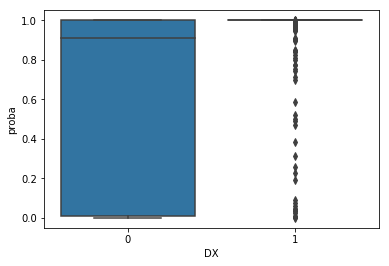

In [26]:
batman = pd.DataFrame({'proba':mciadprob,'DX':testing_mciad_df['DX_bin'].values})
sns.boxplot(x="DX", y="proba", data=batman)
plt.show()

In [27]:
mciadpred = np.where(mciadprob < 0.8,0,1)
print(accuracy_score(testing_mciad_df.DX_bin, mciadpred))

0.6296572280178837


In [28]:
model_dict = {'csf':csfout,'amyloid':amyloidout,'fdg':fdgout,'pet':petout,'mri':mriout}

# training data in ensemble
train_mciad_ensdf = adens.ensembleData(model_dict, training_mciad_df)
train_mciad_ensdf['DX_bin'] = training_mciad_df['DX_bin'].values

# test data in ensemble
test_mciad_ensdf = adens.ensembleData(model_dict, testing_mciad_df)
test_mciad_ensdf['DX_bin'] = testing_mciad_df['DX_bin'].values

# testing data with only MRI present
test2_mciad_ensdf = adens.ensembleData(model_dict, testing2_mciad_df)
test2_mciad_ensdf['DX_bin'] = testing2_mciad_df['DX_bin'].values

In [29]:
for modal_name in ['csf','pet','fdg','amyloid']:
    print("\n"+modal_name.upper() + ":")
    
    # subset of test data for which given modality is present
    mod_testdf = testing2_mciad_df.loc[(testing2_mciad_df[modal_name+'_01']!=-1)]
    modout = model_dict[modal_name]
    
    # prediction of individual model
    predn_model = modout['model'].predict(
        (mod_testdf[modout['features']]-modout['train_mod_mean'])/modout['train_mod_std'])
    print("Individual Model:")
    print("Sensitivity: %.04f, Specificity: %.04f" % adens.SensiSpeci(mod_testdf['DX_bin'], predn_model))
    print("Accuracy: %.04f" % accuracy_score(mod_testdf['DX_bin'], predn_model))

    # prediction of ensemble model
    mod_testensdf = adens.ensembleData(model_dict, mod_testdf)
    predn_ensemble = adens.majorityRule(mod_testensdf) # does not have DX_bin so can simply give the DF as input
    print("Ensemble Model:")
    print("Sensitivity: %.04f, Specificity: %.04f" % adens.SensiSpeci(mod_testdf['DX_bin'], predn_ensemble))
    print("Accuracy: %.04f" % accuracy_score(mod_testdf['DX_bin'], predn_ensemble))


CSF:
Individual Model:
Sensitivity: 73.5294, Specificity: 57.3964
Accuracy: 0.6347
Ensemble Model:
Sensitivity: 84.3137, Specificity: 61.5385
Accuracy: 0.7011

PET:
Individual Model:
Sensitivity: 52.0000, Specificity: 54.0541
Accuracy: 0.5333
Ensemble Model:
Sensitivity: 86.0000, Specificity: 57.8378
Accuracy: 0.6772

FDG:
Individual Model:
Sensitivity: 82.6087, Specificity: 67.0213
Accuracy: 0.7214
Ensemble Model:
Sensitivity: 85.5072, Specificity: 63.4752
Accuracy: 0.7071

AMYLOID:
Individual Model:
Sensitivity: 71.6667, Specificity: 73.0263
Accuracy: 0.7264
Ensemble Model:
Sensitivity: 78.3333, Specificity: 75.6579
Accuracy: 0.7642


In [300]:
kaju=np.zeros((4,4))

In [ ]:
kaju[[1,2,1],[3]]

In [ ]:
np.multiply(np.transpose(X[non_nan_rows,idx_to_update]), np.divide(data_Y[non_nan_rows], 1+np.exp(data_Y[non_nan_rows]*np.dot(X[non_nan_rows,idx_to_update].reshape(-1,1),w[idx_to_update]))))

In [88]:
import time

# train logistic regression model
penalty = 1e1
tstart = time.time()
logregmodel = trainLogisticReg(train_ensdf.drop('DX_bin',axis=1).values,train_ensdf['DX_bin'].values, penalty)
print("time is: %f" %(time.time()-tstart))

# test logistic regression model
training_prob = predictLogisticReg(train_ensdf.fillna(train_ensdf.median()).drop('DX_bin',axis=1).values, logregmodel['coef_'])
predicted_prob = predictLogisticReg(test_ensdf.fillna(train_ensdf.median()).drop('DX_bin',axis=1).values, logregmodel['coef_'])

print("testing AUCROC:", test_performance, ", training AUCROC:", train_performance)

time is: 2.290006
testing AUCROC: 0.9085972850678733 , training AUCROC: 0.9914389199868291


In [ ]:
train_performance = accuracy_score(train_ensdf['DX_bin'].values, np.where(training_prob<0.85,0,1))
test_performance = accuracy_score(test_ensdf['DX_bin'].values, np.where(predicted_prob<0.85,0,1))

print("testing AUCROC:", test_performance, ", training AUCROC:", train_performance)

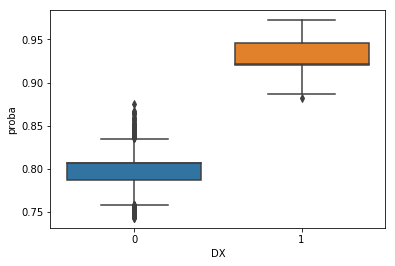

In [89]:
batman = pd.DataFrame({'proba':training_prob,'DX':train_ensdf['DX_bin'].values})
sns.boxplot(x="DX", y="proba", data=batman)
plt.show()

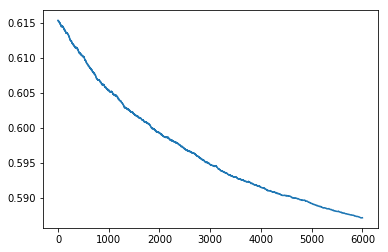

In [71]:
plt.plot(logregmodel['loss'])
plt.show()

In [69]:
def findLoss(x,y,w,penalty_param):
    num_samples = x.shape[0]
#     lossval = np.sum(np.log(1 + np.exp(np.multiply(y, np.dot(x, -w))))) # this one doens't handle nan
#     pdb.set_trace()
    lossval = np.sum(np.log(1 + np.exp(np.multiply(y, -np.nansum(x*w,axis=1)))))
    lossval = lossval/num_samples
    lossval = lossval + penalty_param*(np.linalg.norm(w)**2)/2
    return lossval
   
def gradientDescent(X,data_Y,w,invregparam):
    num_features = X.shape[1]
    num_samples = X.shape[0]
    max_iters = 1000
    step_size = 0.01
    loss = np.zeros(max_iters+1)
    loss[0] = findLoss(X,data_Y,w,1/invregparam)
    
    for iternum in range(0,max_iters):
        # find gradient
        gradient = np.sum(np.multiply(np.transpose(X), np.divide(data_Y, 1+np.exp(data_Y*np.dot(X,w)))), axis=1)
        gradient = -gradient/num_samples + 1/invregparam * w
        
        # do update with gradient       
        w = w - step_size * gradient
        
        # calculate loss
        loss[iternum+1] = findLoss(X,data_Y,w,1/invregparam)
        
    outdict = {'coef_':w, 'loss':loss}
    return outdict   

def coordinateDescent(X,data_Y,w,invregparam):
    
    num_samples, num_features = X.shape    
    max_iters = 1000*num_features
    step_size = 0.01
    loss = np.zeros(max_iters+1)
    loss[0] = findLoss(X,data_Y,w,1/invregparam)

    for iternum in range(0,max_iters):
        # pick coordinate to be updated (here it translates to electrode)
        feat_num = np.random.randint(0, num_features) # if 0, then bias term, otherwise electrode_number + 1 is sampled
        
        # find index of coordinates to update
        if feat_num == 0:
            idx_to_update = [0]
        else:
            idx_to_update = [feat_num] # just keeping it the same for now. Can also send in a bunch of features together
        
        # find gradient for chosen coordinates - modified to handle nan's
        non_nan_rows = np.argwhere(~np.isnan(X[:,idx_to_update]))[:,0]
#         pdb.set_trace()
        gradient = np.sum(np.multiply(np.transpose(X[non_nan_rows,idx_to_update]), \
                                      np.divide(data_Y[non_nan_rows], 1+np.exp(data_Y[non_nan_rows]*np.dot(X[non_nan_rows,idx_to_update].reshape(-1,1),w[idx_to_update]))))) # this is the modified implementation. Original CD takes the entire X and w for dot product
        gradient = -gradient/num_samples + 1/invregparam * w[idx_to_update]
        # do update with gradient for chosen coordinates      
        w[idx_to_update] = w[idx_to_update] - step_size * gradient 
        
        # calculate loss
        loss[iternum+1] = findLoss(X,data_Y,w,1/invregparam) # this loss takes the entire X and w. Also check component-wise loss
        
    outdict = {'coef_':w, 'loss':loss}
    return outdict   

def trainLogisticReg(data_X, data_Y, invregparam):
    
    # prepare training data with appending 1 for bias term
    X = np.hstack((np.ones((data_X.shape[0],1)), data_X))
    num_samples = X.shape[0]
    num_features = X.shape[1] # bias term has been included as feature
    
    # intialize weight vector with number of features in the data + bias term
    w = np.random.uniform(size=(num_features))
    
    outdict = coordinateDescent(X, data_Y, w, invregparam)

    return outdict

def predictLogisticReg(data_X, w):
    # append data with ones for bias term
    X = np.hstack((np.ones((data_X.shape[0],1)), data_X))
    sample_probability = np.reciprocal(1 + np.exp(np.dot(X,-w)))
    return sample_probability